In [2]:
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy import constants as const
from astropy import units as u

import photorates as pr
from photorates.utils import nu2lambda,lambda2nu,spec_nu2lambda,spec_lambda2nu,cm2eV,eV2cm,cm2K,K2cm,spectrum_BB_norm,spectrum_flat

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['font.size'] = 18
mpl.rc('figure',figsize=(10,6),dpi=300)
defcolors=plt.rcParams['axes.prop_cycle'].by_key()['color']

In [11]:
example=np.loadtxt(os.path.join(os.getcwd(), 'inputdata', 'example_spectra', 'exampleSlug.txt'))

In [4]:
times_SEDs=np.logspace(6,9,61)

In [5]:
wl_SEDs=example[0]*u.angstrom

In [6]:
spectra_SEDs=example[1:]*u.erg/u.s/u.angstrom

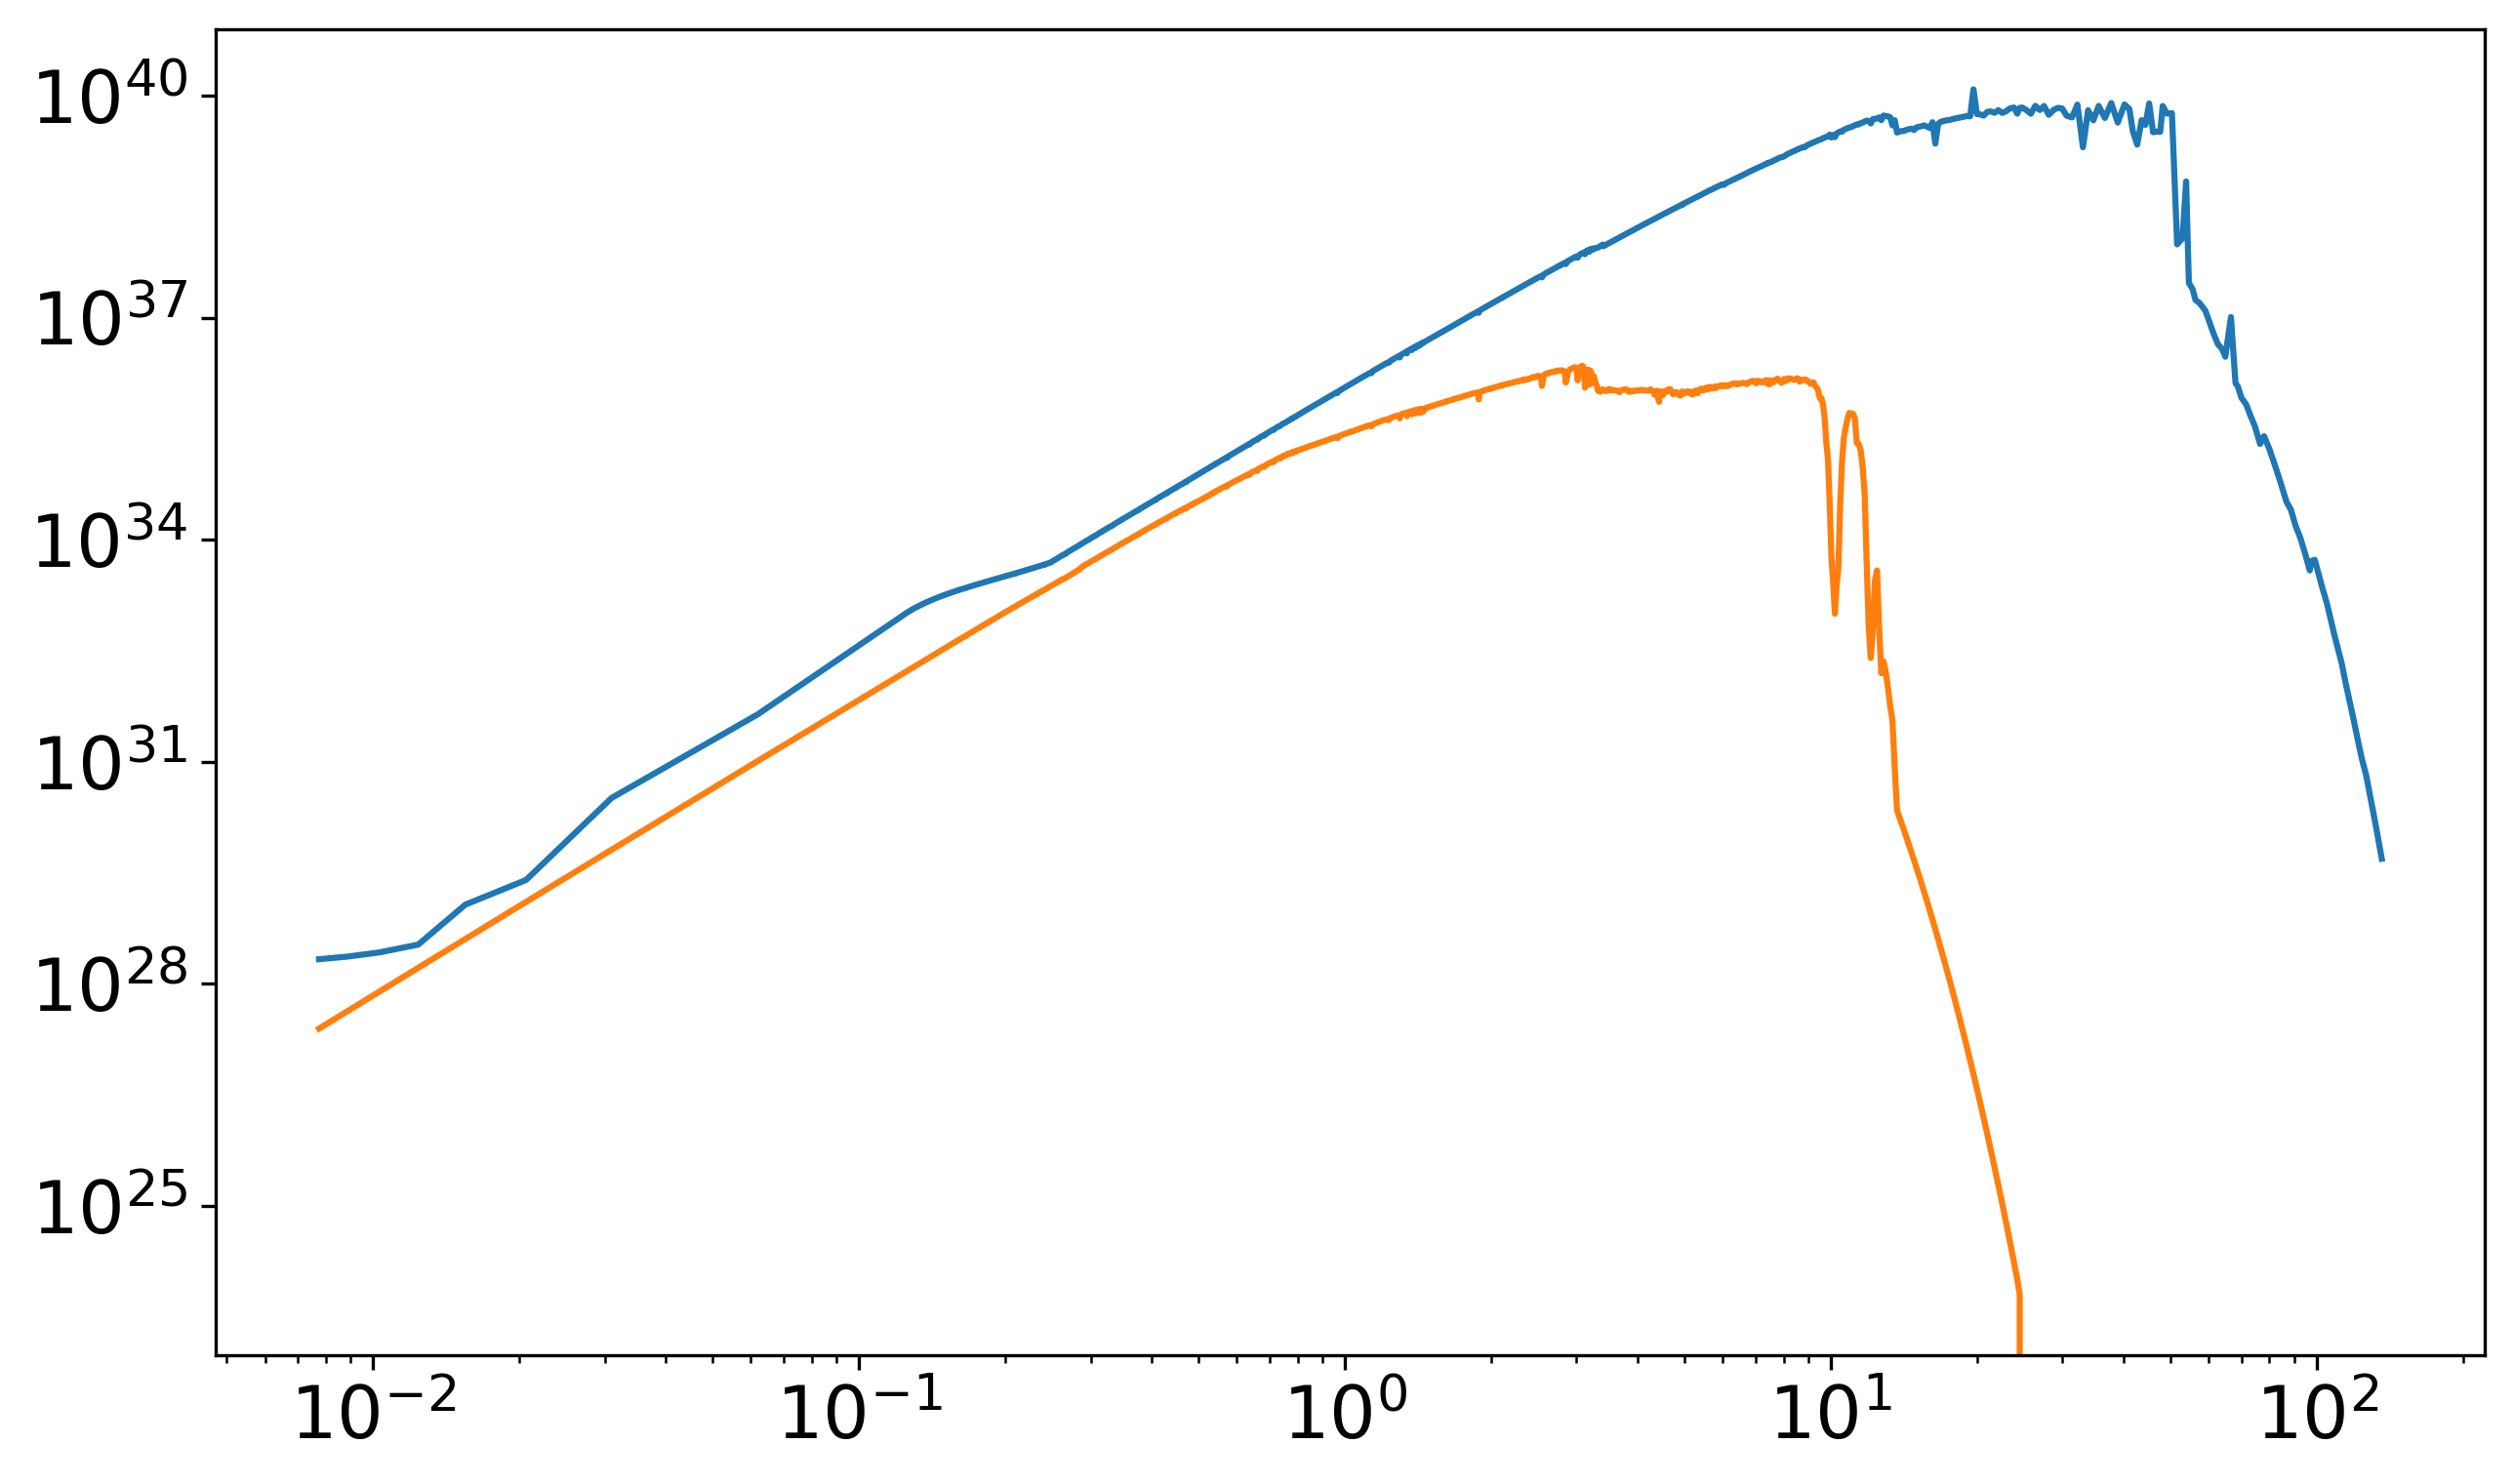

In [7]:
plt.plot(const.h.to(u.eV/u.Hz)*lambda2nu(wl=wl_SEDs),spectra_SEDs[0][::-1])
plt.plot(const.h.to(u.eV/u.Hz)*lambda2nu(wl=wl_SEDs),spectra_SEDs[-1][::-1])
plt.xscale('log')
plt.yscale('log')

In [9]:
kH2=pr.compute_kH2(lambda_array=wl_SEDs,spectra_lambda=spectra_SEDs,thresh_Xlevel=1e-5,thresh_oscxfdiss=1e-6)
kHM=pr.compute_kHM(lambda_array=wl_SEDs,spectra_lambda=spectra_SEDs)
kH2p=pr.compute_kH2p(lambda_array=wl_SEDs,spectra_lambda=spectra_SEDs)

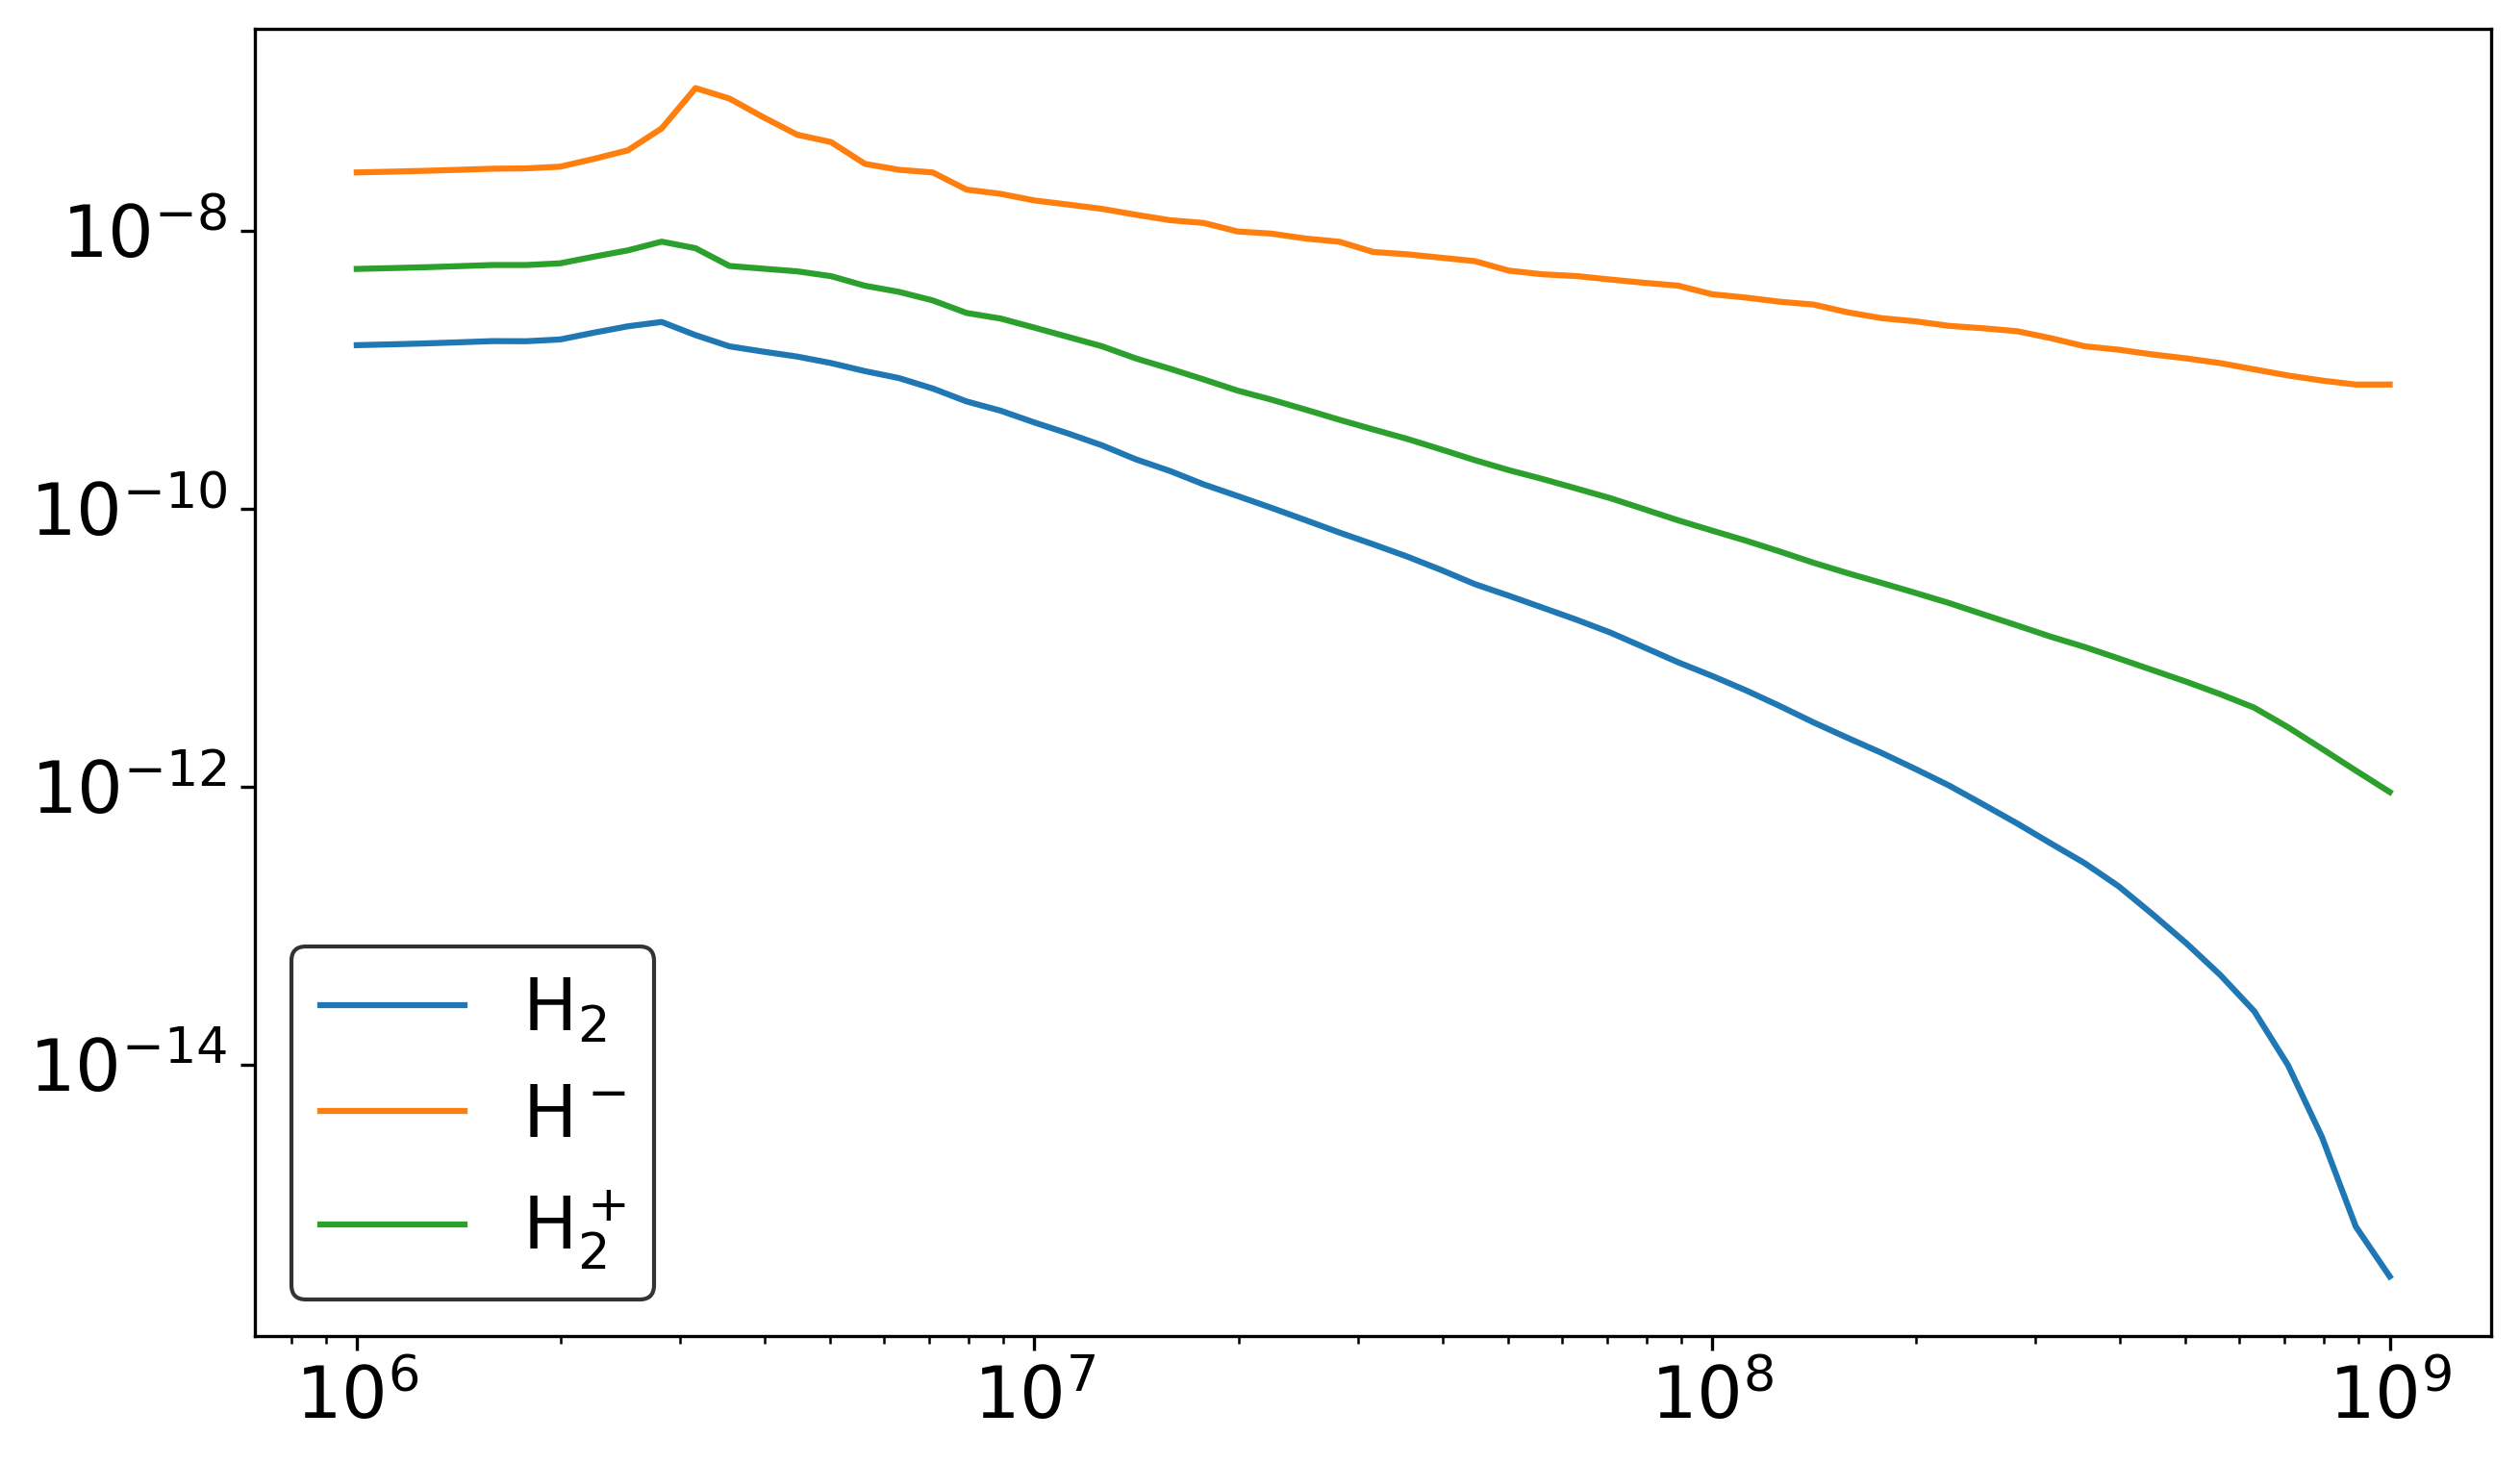

In [11]:
fig,ax=plt.subplots()
ax.plot(times_SEDs,kH2[0],label=r'H$_2$')
ax.plot(times_SEDs,kHM,label=r'H$^-$')
ax.plot(times_SEDs,kH2p[0],label=r'H$_2^+$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(edgecolor='k')

In [3]:
en_arr=np.linspace(start=0.1,stop=13.6,num=int(1e4))*u.eV
freq_arr=en_arr/const.h.to(u.eV/u.Hz)
wl_arr=nu2lambda(freq_arr)

Trad=1e4*u.K
# spectrum_BB_norm gives an intensity [erg/s/Hz/sr/cm^2], transform into luminosity [erg/s/Hz] and then call nu2lambda -> [erg/s/A]
spec_nu=spectrum_BB_norm(Trad=Trad,energies=en_arr)*1e-21*4.*np.pi*u.sr*u.cm**2
spec_lambda=spec_nu2lambda(freq=freq_arr,spec_freq=spec_nu)

# this gives a spherical surface of 1 cm^2
distance=np.sqrt(1./4./np.pi)*u.cm

In [13]:
kHM=pr.compute_kHM(lambda_array=wl_arr,spectra_lambda=spec_lambda,distance=distance.to(u.kpc))
kH2=pr.compute_kH2(lambda_array=wl_arr,spectra_lambda=spec_lambda,distance=distance.to(u.kpc),thresh_Xlevel=1e-5,thresh_oscxfdiss=1e-6)

In [14]:
kHM

<Quantity [1.95547975e-07] 1 / s>

In [15]:
c0=9.08944e-2
c1=3.27940e-5
c2=5.98490e-1
c3=1.09867e1

fit_Latif=np.power(10.,(c0+c1*Trad.value)**(-1./c2)-c3)

In [16]:
fit_Latif

1.9680629737145776e-07

In [17]:
kH2[0]

<Quantity [3.3007991e-12] 1 / s>

In [18]:
spec_nu=spectrum_flat(energies=en_arr)*1e-21*4.*np.pi*u.sr*u.cm**2
spec_lambda=spec_nu2lambda(freq=freq_arr,spec_freq=spec_nu)

# this gives a spherical surface of 1 cm^2
distance=np.sqrt(1./4./np.pi)*u.cm

In [19]:
kH2=pr.compute_kH2(lambda_array=wl_arr,spectra_lambda=spec_lambda,distance=distance.to(u.kpc),thresh_Xlevel=1e-5,thresh_oscxfdiss=1e-6)
kHM=pr.compute_kHM(lambda_array=wl_arr,spectra_lambda=spec_lambda,distance=distance.to(u.kpc))
kH2p=pr.compute_kH2p(lambda_array=wl_arr,spectra_lambda=spec_lambda,distance=distance.to(u.kpc))

In [20]:
kH2[0]

<Quantity [1.45257226e-12] 1 / s>

In [21]:
pr.compute_kH2(lambda_array=wl_arr,spectra_lambda=spec_lambda,distance=distance.to(u.kpc),ngas=1e-1,Tgas=100,thresh_Xlevel=1e-5,thresh_oscxfdiss=1e-6)

/home/andrea/miniconda3/lib/python3.7/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=3.18845e-28): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


(<Quantity [1.41063537e-12] 1 / s>, <Quantity [5.74486003e-13] 1 / s>)

# BBs

In [3]:
en_arr=np.linspace(start=0.1,stop=13.6,num=int(1e4))*u.eV
freq_arr=en_arr/const.h.to(u.eV/u.Hz)
wl_arr=nu2lambda(freq_arr)

all_specs=np.empty(shape=(0,len(wl_arr)))

Trads=np.logspace(start=3.7,stop=5)
Trads=np.concatenate(([0.],Trads))*u.K

for T in Trads:
    if T.value==0:
        spec=spectrum_flat(energies=en_arr)*1e-21*4.*np.pi*u.sr*u.cm**2
    else:
        spec=spectrum_BB_norm(Trad=T,energies=en_arr)*1e-21*4.*np.pi*u.sr*u.cm**2
    spec_lambda=spec_nu2lambda(freq=freq_arr,spec_freq=spec)
    all_specs=np.vstack((all_specs,spec_lambda))

all_specs=u.Quantity(value=all_specs.value,unit=spec_lambda.unit)

# this gives a spherical surface of 1 cm^2
distance=np.sqrt(1./4./np.pi)*u.cm

In [27]:
kH2=pr.compute_kH2(lambda_array=wl_arr,spectra_lambda=all_specs,distance=distance.to(u.kpc),
                   ngas=1e0,Tgas=1e2,thresh_Xlevel=1e-5,thresh_oscxfdiss=1e-6)
kHM=pr.compute_kHM(lambda_array=wl_arr,spectra_lambda=all_specs,distance=distance.to(u.kpc))
kH2p=pr.compute_kH2p(lambda_array=wl_arr,spectra_lambda=all_specs,distance=distance.to(u.kpc),
                    ngas=1e0,Tgas=1e2)

/home/andrea/.local/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/andrea/miniconda3/lib/python3.7/site-packages/frigus/solvers/linear.py:48: LinAlgWarning: Ill-conditioned matrix (rcond=9.93887e-27): result may not be accurate.
  C21 = scipy.linalg.solve(A22, A21)


## H$_2$

In [32]:
c0=1.1735e-1
c1=2.4958e-4
c2=3.4856e-9
c3=1.1902e1
kH2_fitLatif=np.power(10.,(c0+c1*Trads[1:].value+c2*Trads[1:].value**2)**(-1.)-c3)

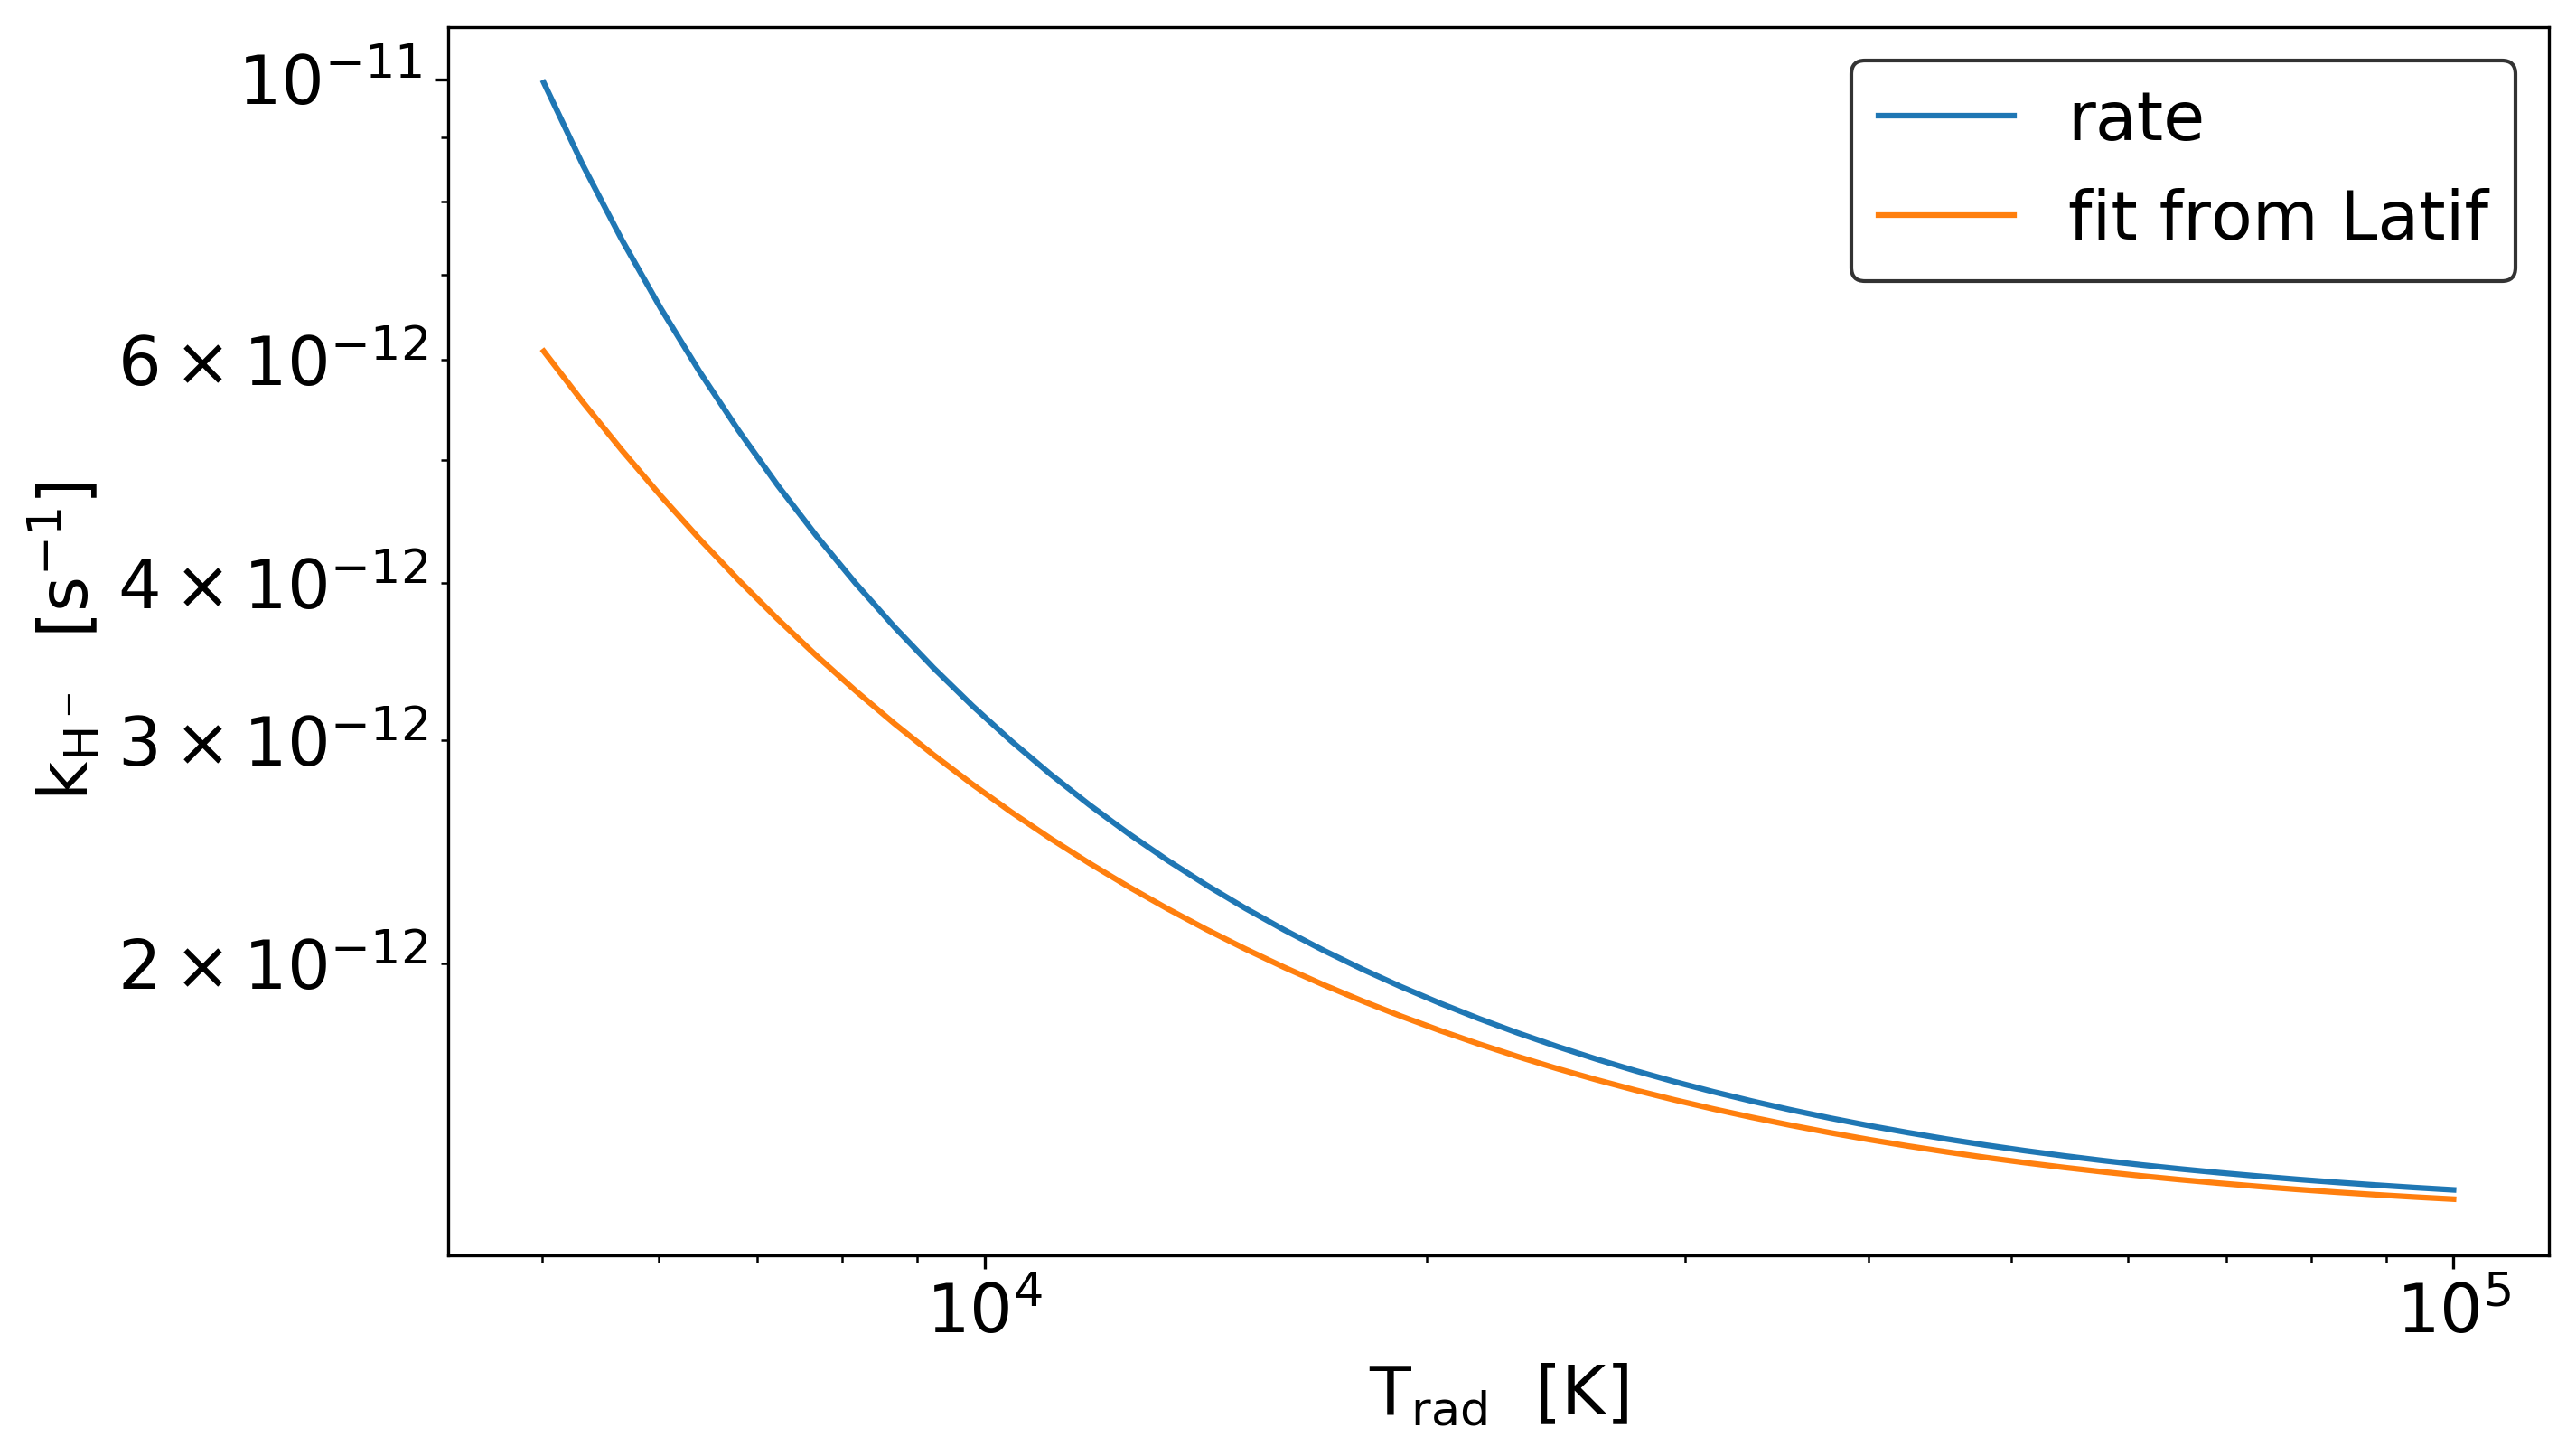

In [35]:
fig,ax=plt.subplots()
ax.plot(Trads[1:],kH2[0][1:],label='rate')
ax.plot(Trads[1:],kH2_fitLatif,label='fit from Latif')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k$_\mathrm{H^-}$  [s$^{-1}$]')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.legend(edgecolor='k',loc='upper right')

## H$^-$

In [30]:
c0=9.08944e-2
c1=3.27940e-5
c2=5.98490e-1
c3=1.09867e1
kHM_fitLatif=np.power(10.,(c0+c1*Trads[1:].value)**(-1./c2)-c3)

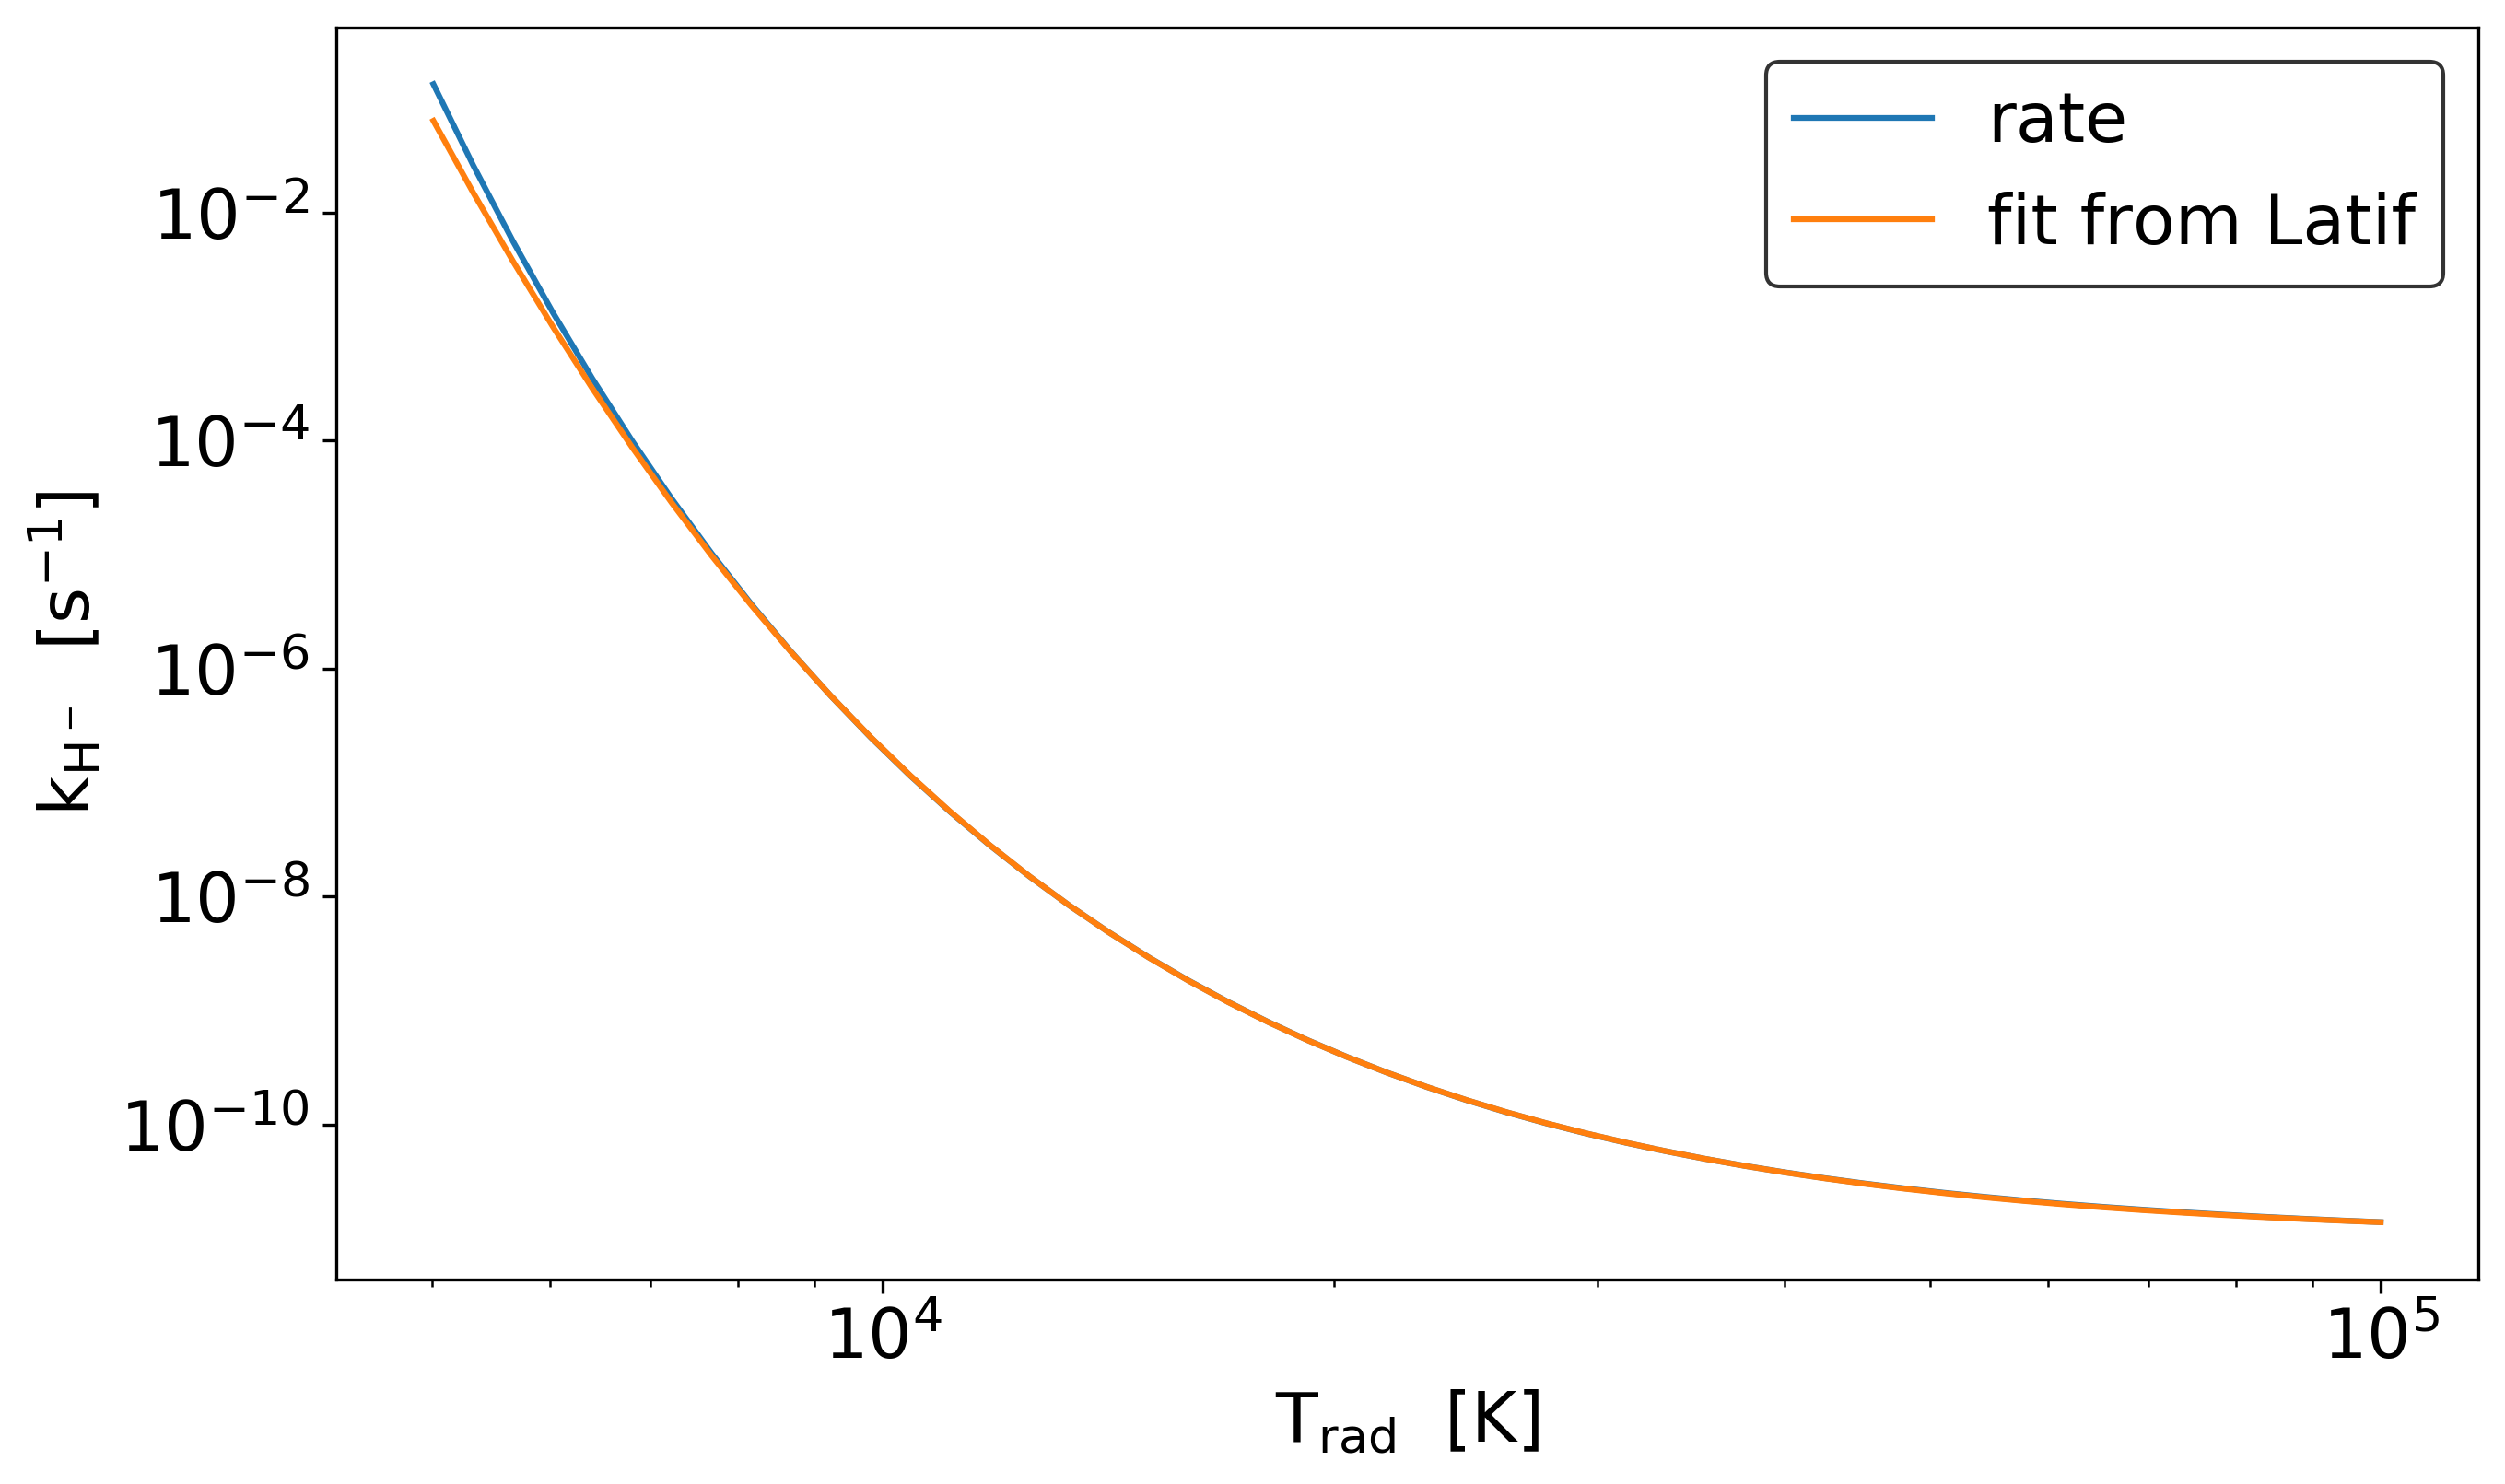

In [31]:
fig,ax=plt.subplots()
ax.plot(Trads[1:],kHM[1:],label='rate')
ax.plot(Trads[1:],kHM_fitLatif,label='fit from Latif')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k$_\mathrm{H^-}$  [s$^{-1}$]')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.legend(edgecolor='k',loc='upper right')

## H$_2^+$

In [36]:
c0=3.83012e6
c1=5.06440e2
c2=6.20988e-1
c3=3.68778e-12
kH2p_fitLatif=(-c0+c1*Trads[1:].value)**(-1./c2)+c3

/home/andrea/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


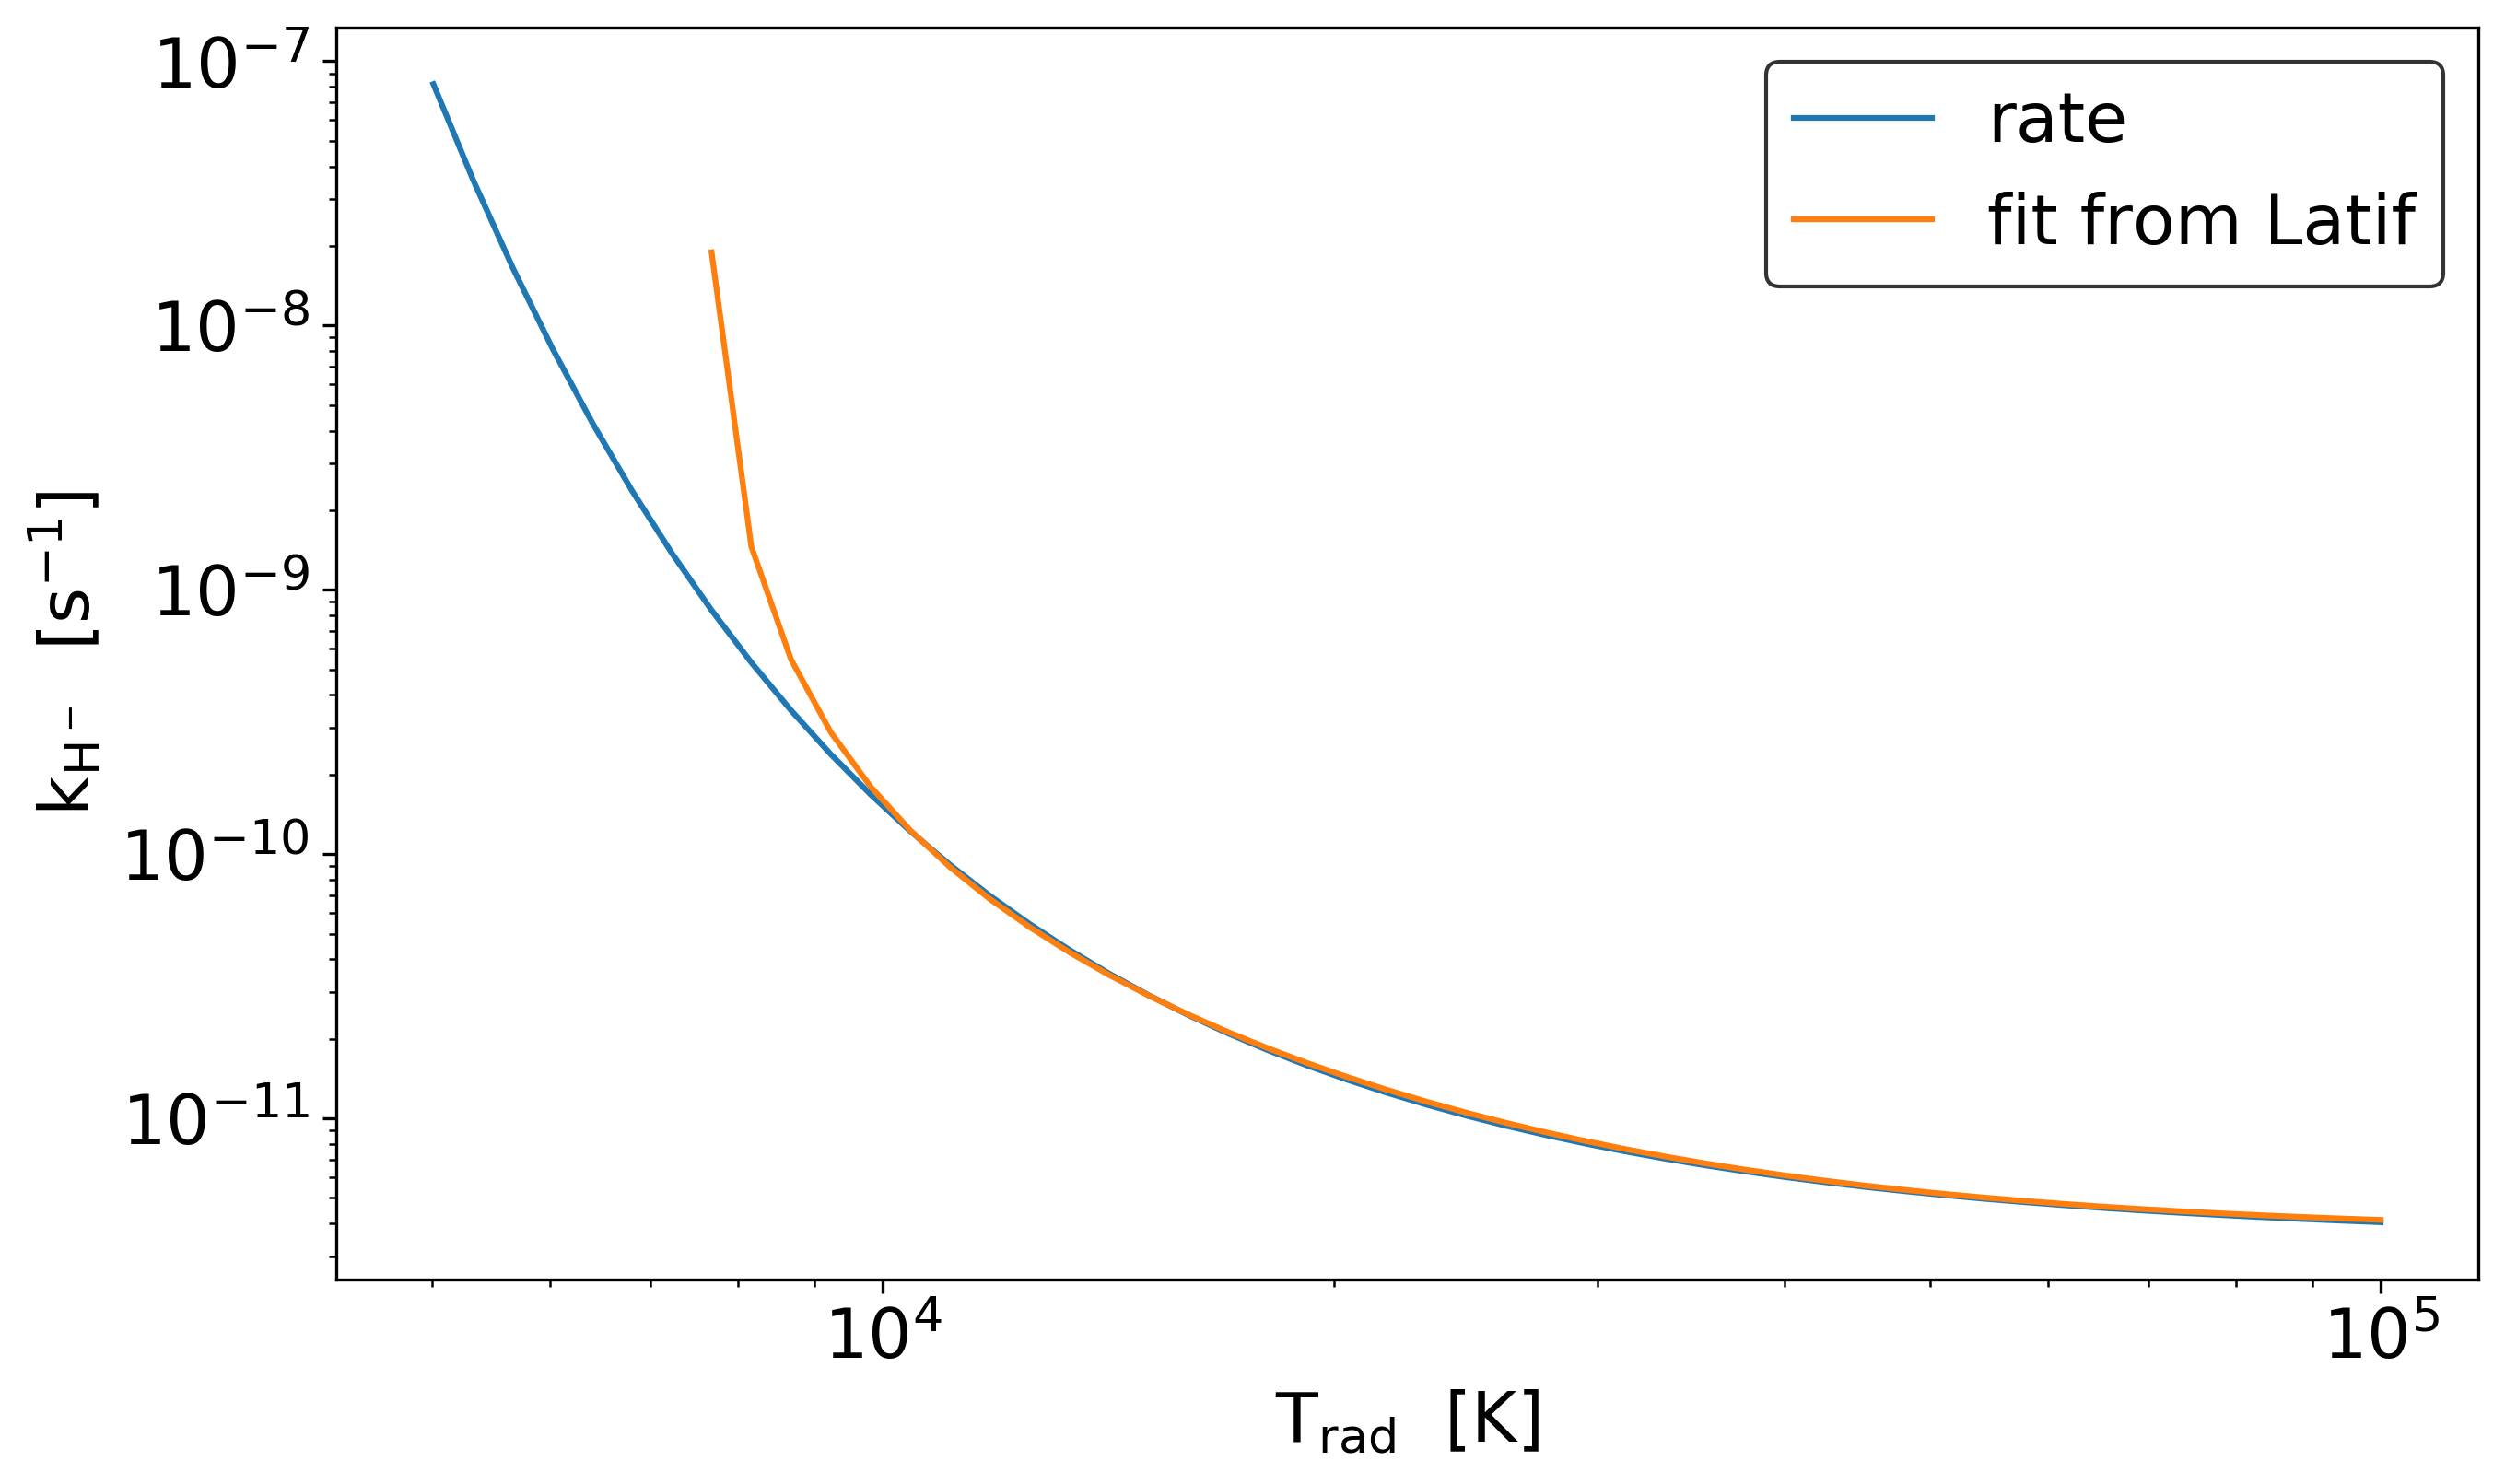

In [37]:
fig,ax=plt.subplots()
ax.plot(Trads[1:],kH2p[0][1:],label='rate')
ax.plot(Trads[1:],kH2p_fitLatif,label='fit from Latif')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'k$_\mathrm{H^-}$  [s$^{-1}$]')
ax.set_xlabel(r'T$_\mathrm{rad}$  [K]')
ax.legend(edgecolor='k',loc='upper right')

In [4]:
pr.compute_kH2p(lambda_array=wl_arr,spectra_lambda=all_specs[0],distance=distance.to(u.kpc),
                    ngas=1e0,Tgas=1e2)

(<Quantity [5.30605915e-12] 1 / s>, <Quantity [4.30431442e-11] eV / s>)

In [5]:
pr.compute_kH2p(lambda_array=wl_arr,spectra_lambda=all_specs[0],distance=distance.to(u.kpc),
                    ngas=1e0,Tgas=1e2,Zammit=False)

(<Quantity [5.30949937e-12] 1 / s>, <Quantity [4.30492202e-11] eV / s>)

In [8]:
pr.compute_kH2p(lambda_array=wl_arr,spectra_lambda=all_specs[0],distance=distance.to(u.kpc),
                    ngas=1e4,Tgas=5e3)

(<Quantity [6.54634138e-12] 1 / s>, <Quantity [3.76466628e-11] eV / s>)

In [9]:
pr.compute_kH2p(lambda_array=wl_arr,spectra_lambda=all_specs[0],distance=distance.to(u.kpc),
                    ngas=1e4,Tgas=5e3,Zammit=False)

(<Quantity [5.13336915e-12] 1 / s>, <Quantity [3.54063335e-11] eV / s>)

In [7]:
pr.H2p.calc_ncrit(Tgas=3e5*u.K)

<Quantity 13.43087052 1 / cm3>